In [2]:
import torch
import pandas as pd
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [91]:
#labels
def read_dataset(path):
  df = pd.read_csv(path)
  df['labels'] = df[df.columns[2:]].values.tolist()
  new_df = df[['comment_text','labels']].copy()
  return new_df


df = read_dataset('/content/drive/MyDrive/jigsaw-toxic-comment-classification-challenge/train.csv')

In [115]:
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig

In [116]:
MAX_LEN = 200
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
EPOCHS = 1
LEARNING_RATE = 1e-05
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [117]:
class ToxicityDataset(Dataset):

  def __init__(self,dataframe,tokenizer,max_len):
    self.tokenizer = tokenizer
    self.data = dataframe
    self.comment_text = dataframe.comment_text
    self.labels = self.data.labels
    self.max_len = max_len

  def __len__(self):
    return len(self.comment_text)

  def __getitem__(self,index):
    comment_text = str(self.comment_text[index])
    comment_text = " ".join(comment_text.split())

    inputs = self.tokenizer.encode_plus(
        comment_text,
        None,
        add_special_tokens=True,
        max_length=self.max_len,
        pad_to_max_length=True,
        return_token_type_ids=True
    )

    ids = inputs['input_ids']
    mask = inputs['attention_mask']
    token_type_ids = inputs['token_type_ids']

    return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.labels[index], dtype=torch.float)
        }

In [118]:
train_dataset=df.sample(frac=0.8,random_state=100)
test_dataset=df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

In [119]:
train_dataset.comment_text

0                                     Hammed it is, cheers!
1         Not a problem, sorry for the inconvenience and...
2         Sources for Gambia at the 2000 Summer Olympics...
3         Added some criticism \n\nI added some much nee...
4         Who cares? It's just a song, it's a great song...
                                ...                        
127652    Question  \nI have seen portions of the discus...
127653           Wow... \n\nSomeone sure is aggressive...XP
127654    "::::This is not 1939 we cannot possibly compa...
127655    Not at all.  It's my talkpage, and you have no...
127656    I wanted to report the vandalism of a\n> user ...
Name: comment_text, Length: 127657, dtype: object

In [120]:
print("FULL Dataset: {}".format(df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))
# train_dataset

train = ToxicityDataset(train_dataset,tokenizer,MAX_LEN)
val = ToxicityDataset(test_dataset,tokenizer,MAX_LEN)

FULL Dataset: (159571, 2)
TRAIN Dataset: (127657, 2)
TEST Dataset: (31914, 2)


In [121]:
train_dataloader = DataLoader(train, batch_size=8,shuffle=True, num_workers=0)
val_dataloader = DataLoader(val, batch_size=4, shuffle=True, num_workers=0)

In [39]:
import transformers

In [3]:
#Create the neural network

class BertClass(torch.nn.Module):
  def __init__(self):
    super(BertClass,self).__init__()
    self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased')
    self.l2 = torch.nn.Dropout(0.3)
    self.l3 = torch.nn.Linear(768,6)

  def forward(self,input_ids,attention_mask,token_type_ids):
    output_1 = self.l1(input_ids, attention_mask= attention_mask, token_type_ids= token_type_ids, return_dict=True,output_attentions=True)
    # print(output_1)
    attention_weights = output_1['attentions']
    pooled_output = output_1.pooler_output
    logits = self.l3(self.l2(pooled_output))
    return logits, attention_weights
    # output_2 = self.l2(output_1)
    # output_3 = self.l3(output_2)
    # return output_3

In [ ]:
model = BertClass()
model.to(device)

In [125]:
def loss_fn(outputs,labels):
  return torch.nn.BCEWithLogitsLoss()(outputs,labels)

In [126]:
optimizer = torch.optim.Adam(params = model.parameters(), lr=LEARNING_RATE)

In [127]:
def train(epoch):
  model.train()
  for _,data in enumerate(train_dataloader,0):
    ids= data['ids'].to(device,dtype=torch.long)
    mask=data['mask'].to(device,dtype=torch.long)
    token_type_ids=data['token_type_ids'].to(device, dtype=torch.long)
    labels = data['targets'].to(device,dtype=torch.float)

    outputs = model(ids,mask,token_type_ids)
    optimizer.zero_grad()
    loss=loss_fn(outputs,labels)

    if _%5000==0:
      print(f'Epoch: {epoch}, Loss:  {loss.item()}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [128]:
len(train_dataloader)

15958

In [ ]:
for epoch in range(1):
  model.train()
  for _,data in enumerate(train_dataloader,0):
    ids= data['ids'].to(device,dtype=torch.long)
    mask=data['mask'].to(device,dtype=torch.long)
    token_type_ids=data['token_type_ids'].to(device, dtype=torch.long)
    labels = data['targets'].to(device,dtype=torch.float)

    outputs = model(ids,mask,token_type_ids)
    optimizer.zero_grad()
    loss=loss_fn(outputs,labels)

    # if _%5000==0:
    print(f'Loss:  {loss.item()}, Iteration: {_} / {len(train_dataloader)}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [136]:
torch.save(model.state_dict(),f'/content/drive/MyDrive/jigsaw-toxic-comment-classification-challenge/model.pt')

In [ ]:
fin_targets=[]
fin_outputs=[]
model.eval()
with torch.no_grad():
  for _,data in enumerate(val_dataloader):
    ids= data['ids'].to(device,dtype=torch.long)
    mask=data['mask'].to(device,dtype=torch.long)
    token_type_ids=data['token_type_ids'].to(device, dtype=torch.long)
    labels = data['targets'].to(device,dtype=torch.float)

    outputs = model(ids,mask,token_type_ids)
    print(f'Iteration {_}/{len(val_dataloader)}')
    fin_targets.extend(labels.cpu().detach().numpy().tolist())
    fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

import numpy as np
outputs = np.array(fin_outputs) >=0.5
targets = fin_targets



In [138]:
from sklearn import metrics

accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.928369994359842
F1 Score (Micro) = 0.787758986748664
F1 Score (Macro) = 0.6428460948857643


### Inference

In [7]:
from transformers import BertTokenizer
import torch.nn.functional as F
import transformers

In [8]:
model = BertClass()
state_dict = torch.load('/content/drive/MyDrive/jigsaw-toxic-comment-classification-challenge/model.pt', map_location=torch.device('cpu'))
model.load_state_dict(state_dict)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

<All keys matched successfully>

In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [10]:
def tokenize_sentences(sentences, tokenizer):
  return tokenizer(sentences,padding=True,truncation=True,return_tensors='pt')

In [81]:
data = ["You're such an idiot.","I will stab you","This is an obscene comment and I will stab you"]

In [82]:
tokenized_input = tokenize_sentences(data,tokenizer)

In [83]:
with torch.no_grad():
  outputs,attention_weight = model(**tokenized_input)

In [84]:
probabilities = F.softmax(outputs, dim=1)

In [85]:
predictions = torch.argmax(probabilities,dim=1).tolist()

In [86]:
classMapping = {'0': "Toxic", "1": "Severe Toxic", "2": "Obscene", "3": "Threat", "4": "Insult", "5": "Identity Hate"}
for i,item in enumerate(predictions):
  print(f' {data[i]} - {classMapping[str(item)]}')

 You're such an idiot. - Toxic
 I will stab you - Toxic
 This is an obscene comment and I will stab you - Toxic


Attention Layer description

1. Number of layers - 12
2. Number of sentences in a batch - N
3. Number of attention heads per layer - 12
4. Number of attention weights for each token - 9

# AI Explanability

In [61]:
import seaborn as sns

In [95]:
selected_attention_weight = attention_weight[11][2][3]
selected_attention_weight.shape

torch.Size([12, 12])

<Axes: >

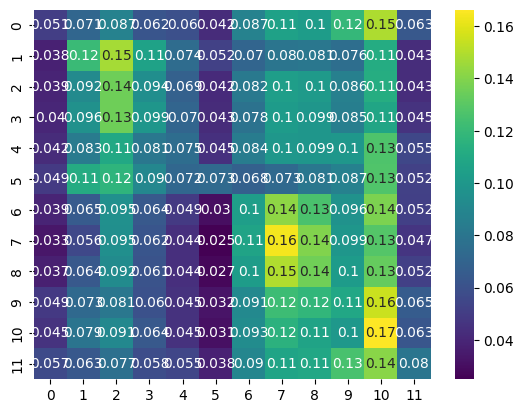

In [96]:
sns.heatmap(selected_attention_weight.detach().numpy(), cmap='viridis', annot=True)